## 项目背景

以淘宝APP平台用户数据为数据集，通过行业的指标对淘宝用户行为进行分析，从而探索淘宝用户的行为模式，具体指标包括：日PV和日UV分析，付费率分析，复购行为分析，漏斗流失分析和用户价值RFM分析。

## 数据来源

[阿里云天池](https://tianchi.aliyun.com/dataset/dataDetail?dataId=46&userId=1)

## 数据说明

该数据集有淘宝APP于2014年11月18日至2014年12月18日的用户行为数据1200万条，数据已经完成脱敏，共计6个字段，分别是：
* user_id：用户身份
* item_id：商品ID
* behavior_type：用户行为类型（包含点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示）
* user_geohash：地理位置（已加密）
* item_category：品类ID（商品所属的品类）
* time：用户行为发生的时间

## 数据清洗

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 读取数据

In [2]:
user_data = pd.read_csv('./tianchi_mobile_recommend_train_user.csv')

### 缺失值处理

In [4]:
user_data.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     8334824
item_category          0
time                   0
dtype: int64

存在缺失值的是User_geohash，有83348245条，因为地理信息在数据集收集过程中做过加密转换，因此不做处理。

### 数据排序

In [3]:
# 按时间升序排列
user_data.sort_values(by='time', inplace=True)

In [4]:
# 重置序号
user_data.reset_index(drop=True, inplace=True)

### 数据拆分

In [5]:
# 提取time中的日期与小时
user_data['date'] = user_data['time'].apply(lambda x: x.split(' ')[0]) 
user_data['hour'] = user_data['time'].apply(lambda x: x.split(' ')[1])

### 数据类型转换

In [6]:
# 数据类型转化
user_data['time'] = pd.to_datetime(user_data['time'])
user_data['date'] = pd.to_datetime(user_data['date'])
user_data['hour'] = user_data['hour'].astype('int64')

In [7]:
user_data.dtypes

user_id                   int64
item_id                   int64
behavior_type             int64
user_geohash             object
item_category             int64
time             datetime64[ns]
date             datetime64[ns]
hour                      int64
dtype: object

### 数据总体情况预览

In [9]:
user_data.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,73462715,378485233,1,NaN,9130,2014-11-18,2014-11-18,0
1,36090137,236748115,1,NaN,10523,2014-11-18,2014-11-18,0
2,40459733,155218177,1,NaN,8561,2014-11-18,2014-11-18,0
3,814199,149808524,1,NaN,9053,2014-11-18,2014-11-18,0
4,113309982,5730861,1,NaN,3783,2014-11-18,2014-11-18,0


In [8]:
user_data.describe()

,user_id,item_id,behavior_type,item_category,hour
count,1.225691e+07,1.225691e+07,1.225691e+07,1.225691e+07,1.225691e+07
mean,7.170732e+07,2.023084e+08,1.105271e+00,6.846162e+03,1.481799e+01
std,4.122920e+07,1.167397e+08,4.572662e-01,3.809922e+03,6.474778e+00
min,4.913000e+03,6.400000e+01,1.000000e+00,2.000000e+00,0.000000e+00
25%,3.584965e+07,1.014130e+08,1.000000e+00,3.721000e+03,1.000000e+01
50%,7.292804e+07,2.021359e+08,1.000000e+00,6.209000e+03,1.600000e+01
75%,1.073774e+08,3.035405e+08,1.000000e+00,1.029000e+04,2.000000e+01
max,1.424559e+08,4.045625e+08,4.000000e+00,1.408000e+04,2.300000e+01


## 用户行为分析

### 名词解释

PV(访问量)：即Page View, 指网站的页面浏览量或者点击量，页面刷新一次就计算一次。

UV(独立访客)：即Unique Visitor,访问网站的一台电脑客户端（IP）为一个访客。

### 日访问量分析

In [12]:
# pv_daily记录每天用户操作次数
pv_daily = user_data.groupby('date')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})

In [14]:
# uv_daily记录每天不同的上线用户数量
uv_daily = user_data.groupby('date')['user_id'].apply(lambda x : x.drop_duplicates().count()).reset_index().reset_index().rename(columns={'user_id':'uv'})

Text(0.5, 1.0, 'uv_daily')

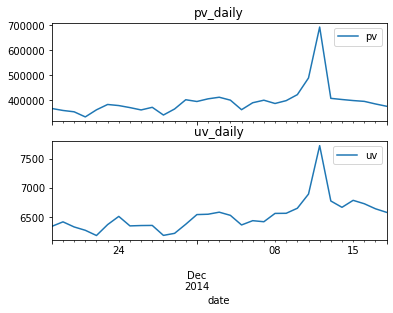

In [16]:
fig, axes = plt.subplots(2, 1, sharex=True)
pv_daily.plot(x='date', y='pv', ax=axes[0])
uv_daily.plot(x='date', y='uv', ax=axes[1])
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')

In [23]:
# 数据集中用户样本数
len(user_data['user_id'].unique())

10000

在双12期间，访问量与浏览量都达到了峰值水平，但是，PV与UV的数值差异较大,由于数据集中的用户数量是10000，因而可以测算出，双12期间淘宝用户日活跃处于50%浮动区间，其中在12日当天达到顶峰，活跃率80%。

### 时段访问量分析

In [10]:
# pv_hour记录每小时用户浏览次数
pv_hour = user_data.groupby('hour')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})

In [11]:
# uv_hour记录每小时用户数
uv_hour = user_data.groupby('hour')['user_id'].apply(lambda x : x.drop_duplicates().count()).reset_index().reset_index().rename(columns={'user_id':'uv'})

Text(0.5, 1.0, 'uv_hour')

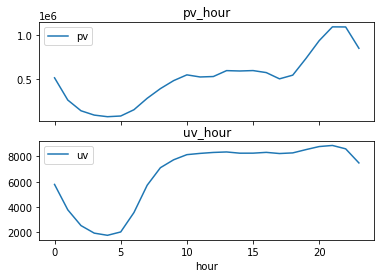

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True)
pv_hour.plot(x='hour', y='pv', ax=axes[0])
uv_hour.plot(x='hour', y='uv', ax=axes[1])
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')

数据显示：0~5点，无论是UV还是PV数据都呈大幅下降趋势，触底后反弹，其中，UV趋势要比PV明显；在傍晚18点左右，PV数据开始大幅上升，这也是用户的活跃时段。

### 用户行为分析

In [21]:
# 不同行文在不同时段的PV数据
pv_detail = user_data.groupby(['behavior_type','hour'])['user_id'].count().reset_index().rename(columns={'user_id': 'total_pv'})

Text(0.5, 1.0, 'pv_different_behavior_type_except_click')

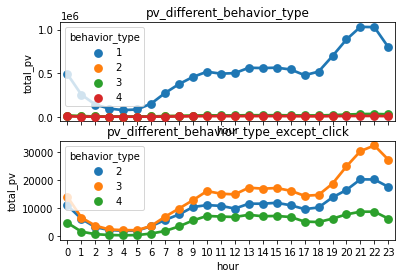

In [23]:
fig, axes = plt.subplots(2, 1, sharex=True)
sns.pointplot(x='hour', y='total_pv', hue='behavior_type', data=pv_detail, ax=axes[0])
sns.pointplot(x='hour', y='total_pv', hue='behavior_type', data=pv_detail[pv_detail.behavior_type !=1 ], ax=axes[1])
axes[0].set_title('pv_different_behavior_type')
axes[1].set_title('pv_different_behavior_type_except_click')

点击行为的的PV访问量较其他3种用户行为较高，其他3种用户行为的数据变化趋势大体一致；晚上的用户访问量最大，同时根据表2可以看出，加购物车用户行文的PV浏览量要明显高于收藏行为，因此在后续漏斗流失分析中，用户类型3应该在2之前分析。

## 消费行为分析

### 用户购买次数分析

In [28]:
# 获取用户购买次数信息
user_buy = user_data[user_data['behavior_type']==4].groupby('user_id')['behavior_type'].count()

Text(0.5, 1.0, 'daily_user_buy')

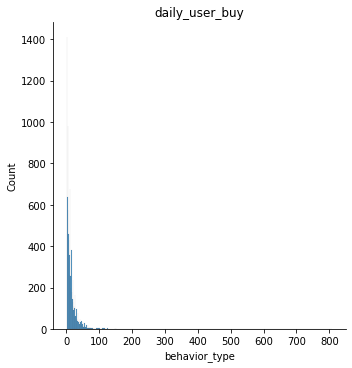

In [32]:
sns.displot(user_buy, kde=False)
plt.title('daily_user_buy')

数据显示，淘宝用户消费次数普遍在10次左右，随着消费次数下降，消费人数也随之下降。

### 付费率分析

Text(0.5, 1.0, 'daily_afford_rate')

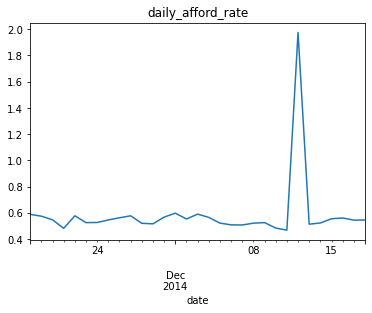

In [38]:
user_data.groupby('date').apply(lambda x:x[x.behavior_type==4]['behavior_type'].count()/len(x.user_id.unique())).plot()
plt.title('daily_afford_rate')

### 消费次数分析

In [55]:
user_buy_times = user_data[user_data.behavior_type==4].groupby(['user_id','date','hour'])['behavior_type'].sum()

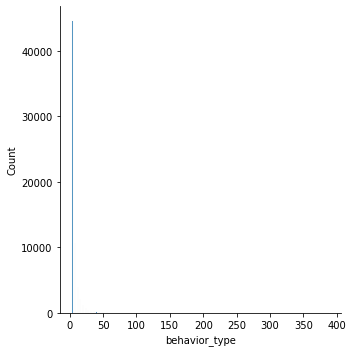

In [56]:
sns.displot(user_buy_times)

绝大多数用户的购买次数都在5次左右。

## 复购情况分析

### 复购率

复购情况，即两天以上有购买行为,一天多次购买算一次。

复购率 = 有复购行为的用户数/有购买行为的用户总数。

In [59]:
rebuy_data = user_data[user_data['behavior_type']==4].groupby('user_id')['date'].apply(lambda x:len(x.unique())).rename('rebuy_count')

In [70]:
rebuy_data[rebuy_data>1].count()/rebuy_data.count()

0.8717083051991897